In [163]:
import librosa
import numpy as np
import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import f1_score

In [164]:
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
from mutagen.wave import WAVE
import sys
import librosa
import os

In [165]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/dsl_data.zip', 'r') 
zip_ref.extractall('/tmp')
zip_ref.close()

In [166]:
import pandas as pd
dev= pd.read_csv('/tmp/development.csv')
dev.shape

(9854, 10)

In [167]:
import pandas as pd
val= pd.read_csv('/tmp/evaluation.csv')
val.shape

(1455, 8)

In [8]:
df= pd.concat([dev, val], axis= 0)
df.shape

(11309, 10)

In [9]:
df['audio_name'] = df['path'].apply(lambda x: x.split('/')[-1].split('.')[0])
df.drop('path', inplace=True, axis=1)
df.shape

(11309, 10)

In [10]:
import glob
pathtrain =[]
pathtest =[]
path_nonzero = []
for file in glob.glob('/tmp/audio/speakers/*'):
  for i in glob.glob(file + '/*.wav'):
    id= i.split('/')[-1].split('.')[0]
    if (list(df['action'][df['audio_name']== id].isna())[0]): 
      pathtest.append(i)
    else:
      pathtrain.append(i)

print(len(pathtrain),len(pathtest))

9854 1455


In [168]:
def feature_extract(path):
    y, sr = librosa.load(path, sr= 16000, offset=0.0, duration=5.0)
    ###padding to 5 seconds
    current_length = len(y)
    padding = int(5 * sr) - current_length
    y_pad = np.pad(y, (0, padding), mode='constant')
    ##### extracting featuers
    mfcc = librosa.feature.mfcc(y= y_pad, sr= sr, n_fft= 1024, hop_length= 512, fmax= 8000, n_mfcc= 50)
    return mfcc

In [ ]:
#######features of audio
lis= []
dic= {}
for i in pathtrain:
  id= i.split('/')[-1].split('.')[0]
  feature= feature_extract(i)
  lis.append(feature)
  dic[id]= feature

In [134]:
###### labels
yy=[]
for file in pathtrain:
  id= file.split('/')[-1].split('.')[0]
  action=list(df['action'][df['audio_name']== id])[0]
  objject=list(df['object'][df['audio_name']== id])[0]
  result= str(action) + str(objject)
  yy.append(result)

In [135]:
#####check size of audios
a= []
for i in range(0, len(lis)):
  c= lis[i].shape[1]
  a.append(c)

In [136]:
print(np.min(a), np.max(a))

157 157


In [137]:
lis[0].shape

(50, 157)

In [138]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(lis, yy, test_size=0.2, random_state=42, stratify= yy)

# # Encode the labels as integers
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)

y_test = encoder.transform(y_test)

# # Reshape the data to be in the form (samples, height, width, channels)
X_train = np.reshape(X_train, (-1, 50, 157, 1))
X_test = np.reshape(X_test, (-1, 50, 157, 1))

In [115]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
class_weights = dict(enumerate(class_weights))

In [145]:
# Create the model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(50, 157, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(len(encoder.classes_), activation='softmax'))

# Compile and train the model
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [146]:
checkpoint= "weights_mfcc.{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.hdf5"
model_checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint, save_freq="epoch",
        save_best_only=True, save_weights_only=False, monitor='val_accuracy')

In [147]:
net= model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), shuffle= True, callbacks= [model_checkpoint_callback], class_weight=class_weights)

Epoch 1/50
247/247 [==============================] - 4s 14ms/step - loss: 1.8289 - accuracy: 0.2481 - val_loss: 1.7480 - val_accuracy: 0.2704
Epoch 2/50
247/247 [==============================] - 3s 13ms/step - loss: 1.5252 - accuracy: 0.3268 - val_loss: 1.5357 - val_accuracy: 0.3577
Epoch 3/50
247/247 [==============================] - 3s 13ms/step - loss: 1.1375 - accuracy: 0.4949 - val_loss: 1.0196 - val_accuracy: 0.5698
Epoch 4/50
247/247 [==============================] - 3s 13ms/step - loss: 0.8548 - accuracy: 0.5917 - val_loss: 1.0064 - val_accuracy: 0.5703
Epoch 5/50
247/247 [==============================] - 3s 13ms/step - loss: 0.6961 - accuracy: 0.6485 - val_loss: 0.8510 - val_accuracy: 0.6149
Epoch 6/50
247/247 [==============================] - 3s 13ms/step - loss: 0.5758 - accuracy: 0.6977 - val_loss: 0.7428 - val_accuracy: 0.6814
Epoch 7/50
247/247 [==============================] - 3s 13ms/step - loss: 0.5104 - accuracy: 0.7369 - val_loss: 0.7516 - val_accuracy: 0.6895

In [148]:
print(net.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


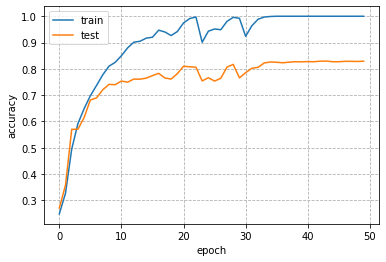

In [162]:
plt.plot(net.history['accuracy'])
plt.plot(net.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(linestyle='--')
plt.savefig("epochs.png", format="png", dpi= 1200)
plt.show()

In [150]:
#####evaluate on X_test
p= []
for i in X_test:
  X_test = np.reshape(i, (-1, 50, 157, 1))
  pred= model.predict(X_test, verbose= 0)
  p.append(pred)

In [151]:
result= []
for i in p:
  arg= np.argmax(i)
  result.append(arg)

In [152]:
from sklearn import metrics
print(metrics.f1_score(result, y_test, average= 'macro'), metrics.accuracy_score(result, y_test))

0.8460498562436314 0.8290208016235413


Test

In [153]:
#######features for evalution set
lis_test= []
Id= []
for i in pathtest:
  audio_id= i.split('/')[-1].split('.')[0]
  id= list(df['Id'][df['audio_name'] == audio_id])[0]
  feature= feature_extract(i)
  lis_test.append(feature)
  Id.append(id)

In [154]:
p= []
for i in lis_test:
  X_test = np.reshape(i, (-1, 50, 157, 1))
  pred= model.predict(X_test, verbose= 0)
  p.append(pred)

In [155]:
result= []
for i in p:
  arg= np.argmax(i)
  result.append(arg)

In [156]:
predict= pd.DataFrame(encoder.inverse_transform(list(result)), columns= {'Predicted'})

In [157]:
Id= pd.DataFrame(Id, columns= {'Id'})

In [158]:
res= pd.concat([Id, predict], axis= 1)
res.shape

(1455, 2)

In [159]:
res= res.sort_values(by=['Id'])

In [160]:
res.to_csv('/content/drive/MyDrive/cnn_mfcc_final.csv')